In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
path = r"Proposal/Figures/"
table_path = r"Proposal/Tables/"

In [4]:
def function_z_k(α,γ,r_b, green_premium,τ_E,A_tilde):
    r_g = (1-green_premium) * r_b
    return (α/(1-α) * (r_b +τ_E/1000*A_tilde )/r_g) ** (1/γ)
def function_z_l(z_k,β,α,γ,w,green_premium,r_b):
    r_g = (1-green_premium) * r_b
    return (((1-β)/β) /(α) )* ((α + (1-α)*(z_k** (1-γ)) ) ** (1/(1-γ))) * (r_g/w)

def function_intensity(A_tilde,A_hat,α,γ,z_l,z_k,β):
    return (A_tilde/A_hat) * (α * (z_k ** (γ-1)) + (1 - α)) ** (γ / (1-γ)) * (z_l ** (1-β))

def function_price(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E):
    r_g = (1-green_premium) * r_b
    C_G = r_g * (((α + (1-α)*(z_k** (1-γ)) ) ** (γ / (1-γ))) * (z_l ** (1-β)))
    C_B = r_b * ((α * (z_k ** (γ-1)) + (1 - α)) ** (γ / (1-γ))) * (z_l ** (1-β))
    c_L = w * z_l ** (-β)
    C_E = τ_E/1000 * A_tilde * C_B/r_b
    return σ/(σ-1) * (C_G + C_B + c_L + C_E) / A_hat

    
def production_function(A_hat,β,z_l,L):
    return A_hat * (z_l ** (β)) * L

def brown_capital(A_hat,α,z_k,z_l,γ,β,Y):
    return (Y/A_hat) * ((α * (z_k ** (γ-1)) + (1 - α)) ** (γ / (1-γ))) * (z_l ** (1-β))
def green_capital(A_hat,α,z_k,z_l,γ,β,Y):
    return (Y/A_hat) * ((α + (1-α)*(z_k** (1-γ)) ) ** (γ / (1-γ))) * (z_l ** (1-β))

def simulate_firms(n,A_tilde,A_hat,L,α,γ,r_b, green_premium,τ_E,β,w,σ):
    # simulate over multiple firms
    r_g = (1-green_premium) * r_b
    np.random.seed(0)
    A_tilde_vector = (1 + np.random.lognormal(mean=0,sigma=1,size=n)) * A_tilde
    A_hat_vector = (1 + np.random.lognormal(mean=0,sigma=1,size=n)) * A_hat
    L_vector = (np.random.lognormal(mean=-1.3,sigma=1.8,size=n)) * L
    intensity = []
    production = []
    emissions = []
    emission_cost = []
    G_c = []
    B_c = []
    for i in zip(A_tilde_vector,A_hat_vector,L_vector):
        z_k = function_z_k(α,γ,r_b, green_premium,τ_E,i[0])
        z_l = function_z_l(z_k,β,α,γ,w,green_premium,r_b)
        IN = function_intensity(i[0],i[1],α,γ,z_l,z_k,β)
        Y = production_function(i[1],β,z_l,i[2])
        intensity.append(IN)
        production.append(Y)
        emissions.append(IN * Y)
        emission_cost.append(τ_E/1000 * IN * Y)
        G_c.append(green_capital(i[1],α,z_k,z_l,γ,β,Y))
        B_c.append(brown_capital(A_hat,α,z_k,z_l,γ,β,Y))
    return CES_aggregator(emissions,np.inf),CES_aggregator(production,σ),sum(intensity)/n,production,emission_cost,G_c,B_c
def CES_aggregator(array,σ):
    if σ != np.inf:
        return sum([i ** ((σ-1)/σ) for i in array]) ** (σ/(σ-1))
    else:
        return sum(array)


In [5]:
params = {
    'β': 0.6,
    'γ': 10.34,
    'α': 0.25,
    'A_hat': 0.1,
    'A_tilde': 0.018,
    'L': 250,
    'μ': 0,
    'θ': 1,
    'η': np.inf,
    'σ': np.inf,
    'r_b': 0.05,
    'green_premium': 0,
    'w': 0.500, # MSEK
    'τ_E': 0, # per ton
    'n': int(1e3)}

# CO2 Emission is 13800 Kton
# Labor 500 TSEK


z_k = function_z_k(params['α'],params['γ'],params['r_b'], params['green_premium'],params['τ_E'],params['A_tilde'])
z_l = function_z_l(z_k,params['β'],params['α'],params['γ'],params['w'],params['green_premium'],params['r_b'])
print("z_k: ",z_k)
print("z_l: ",z_l)
print("intensity: (KG/SEK) ",function_intensity(params['A_tilde'],params['A_hat'],params['α'],params['γ'],z_l,z_k,params['β']))
print("production: (MSEK)",production_function(params['A_hat'],params['β'],z_l,params['L'])/1e3)
print("emission: (ton)",function_intensity(params['A_tilde'],params['A_hat'],params['α'],params['γ'],z_l,z_k,params['β']) * production_function(params['A_hat'],params['β'],z_l,params['L']))
print("-"*50)
emission, production, intensity, _, emission_cost, G_c, B_c = simulate_firms(params['n'],params['A_tilde'],params['A_hat'],params['L'],params['α'],params['γ'],params['r_b'], params['green_premium'],params['τ_E'],params['β'],params['w'],params['σ'])
print("Intensity: (KG/SEK)",intensity)
print("Emission: (MTon) ",emission/1e6)
print("Production: (BSek) ",production/1e6)
print("Emission/Production: (KG/SEK) ",emission/production)
print("Emission cost: ",sum(emission_cost))
print("Green Capital: ",sum(G_c))
print("Brown Capital: ",sum(B_c))

z_k:  0.8992009254377683
z_l:  0.24422200220230172
intensity: (KG/SEK)  0.12379003471142418
production: (MSEK) 0.010730275709520641
emission: (ton) 1.3283012025447118
--------------------------------------------------
Intensity: (KG/SEK) 0.1580798627550469
Emission: (MTon)  0.002934341902006237
Production: (BSek)  0.026547611262035097
Emission/Production: (KG/SEK)  0.11053129688555244
Emission cost:  0.0
Green Capital:  23508.71660909485
Brown Capital:  182573.8733129289


In [14]:
def function_price(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E):
    C_G,C_B,c_L,C_E = function_price_detail(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E)
    return σ/(σ-1) * (C_G + C_B + c_L + C_E) / A_hat
    
def function_price_detail(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E):
    r_g = (1-green_premium) * r_b
    C_G = r_g * ((α * (z_k ** (γ-1)) + (1 - α)) ** (γ / (1-γ))) * (z_l ** (1-β))
    C_B = r_b * (((α + (1-α)*(z_k** (1-γ)) ) ** (γ / (1-γ))) * (z_l ** (1-β)))
    c_L = w * z_l ** (-β)
    C_E = τ_E/1000 * A_tilde * C_B/r_b
    return C_G,C_B,c_L,C_E


def optimal_labor(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E,ν=1e5):
    p = function_price(A_tilde,A_hat,α,γ,z_l,z_k,β,w,green_premium,r_b,σ,τ_E)
    return ν * z_l ** (-β) * (p ** (-σ))/A_hat

def ratios_gen(input_0):
    z_k = function_z_k(input_0['α'],input_0['γ'],input_0['r_b'], input_0['green_premium'],input_0['τ_E'],input_0['A_tilde'])
    z_l = function_z_l(z_k,input_0['β'],input_0['α'],input_0['γ'],input_0['w'],input_0['green_premium'],input_0['r_b'])
    l = optimal_labor(input_0['A_tilde'],input_0['A_hat'],input_0['α'],input_0['γ'],z_l,z_k,input_0['β'],input_0['w'],input_0['green_premium'],input_0['r_b'],input_0['σ'],input_0['τ_E'])
    y = production_function(input_0['A_hat'],input_0['β'],z_l,l)
    p = function_price(input_0['A_tilde'],input_0['A_hat'],input_0['α'],input_0['γ'],z_l,z_k,input_0['β'],input_0['w'],input_0['green_premium'],input_0['r_b'],input_0['σ'],input_0['τ_E'])
    intensity = function_intensity(input_0['A_tilde'],input_0['A_hat'],input_0['α'],input_0['γ'],z_l,z_k,input_0['β'])
    return z_k,z_l,l,y*1e3,p, intensity, intensity*y*1e3

def gen_df(params,τ_E):
    params_0 = params.copy()
    params_0['σ'] = 5
    # params_0['w'] = params['w'] / 1e3
    params_0['τ_E'] = τ_E #* 1e2
    params_1 = params_0.copy()
    res_1 = ratios_gen(params_1)
    params_2 = params_0.copy()
    params_2['A_hat'] = params_2['A_hat'] * 0.9
    params_2['A_tilde'] = params_2['A_tilde'] * 1.1
    res_2 = ratios_gen(params_2)
    # put the results into a dataframe
    df = pd.DataFrame([res_1,res_2],columns=['z_k','z_l','l','y','p','intensity','emission'])
    df['income'] = (df.y * df.p).round(2)
    df['emission'] = df.emission.round(2)
    # add sum row
    df.loc['sum'] = np.nan
    df.loc['sum','l']= df.l.sum()
    df.loc['sum','emission']= df.emission.sum()
    df.loc['sum','income']= df.income.sum()
    p_s = 0
    y_s = 0
    for i in [res_1,res_2]:
        p_s += i[4] ** (1-params_0['σ'])
        y_s += i[3] ** ((params_0['σ']-1)/(params_0['σ']))
    p_s = p_s ** (1/(1-params_0['σ']))
    y_s = y_s ** (params_0['σ']/(params_0['σ']-1))
    df.loc['sum','p'] = p_s
    # df.p = df.p/p_s
    df.loc['sum','y'] = y_s
    return df

tax = 20
tax_2 = -20
df = pd.concat([gen_df(params,tax_2),gen_df(params,0),gen_df(params,tax)],keys=['τ_E = {}'.format(tax_2),'τ_E = 0','τ_E = {}'.format(tax)],axis=0)
df


z_k       z_l         l           y          p  intensity  \
τ_E = -20 0    0.898573  0.244070  2.931514  125.776861  15.138396   0.123857   
          1    0.898510  0.244055  1.923202   74.260845  16.820853   0.151389   
          sum       NaN       NaN  4.854716  236.285891  13.344811        NaN   
τ_E = 0   0    0.899201  0.244222  2.933996  125.930346  15.134704   0.123790   
          1    0.899201  0.244222  1.924995   74.360610  16.816337   0.151299   
          sum       NaN       NaN  4.858991  236.585756  13.341427        NaN   
τ_E = 20  0    0.899825  0.244373  2.936434  126.081674  15.131069   0.123723   
          1    0.899887  0.244388  1.926753   74.458834  16.811898   0.151208   
          sum       NaN       NaN  4.863187  236.881231  13.338097        NaN   

               emission   income  
τ_E = -20 0       15.58  1904.06  
          1       11.24  1249.13  
          sum     26.82  3153.19  
τ_E = 0   0       15.59  1905.92  
          1       11.25  1250.47  
          sum     26.84  3156.39  
τ_E = 20  0       15.60  1907.75  
          1       11.26  1251.79  
          sum     26.86  3159.54

In [7]:
params

{'β': 0.6,
 'γ': 10.34,
 'α': 0.25,
 'A_hat': 0.1,
 'A_tilde': 0.018,
 'L': 250,
 'μ': 0,
 'θ': 1,
 'η': inf,
 'σ': inf,
 'r_b': 0.05,
 'green_premium': 0,
 'w': 0.5,
 'τ_E': 0,
 'n': 1000}

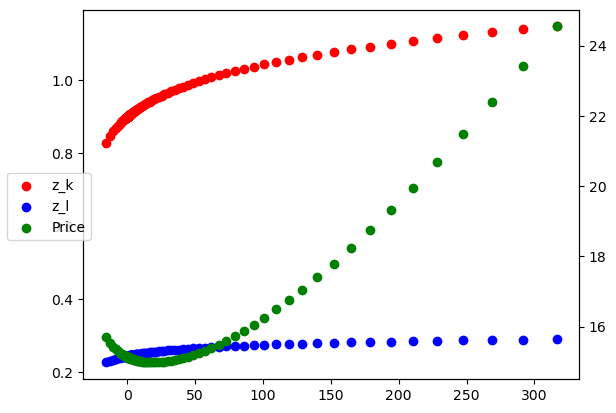

In [20]:
def price_test(input_0,τ_E):
    z_k = function_z_k(input_0['α'],input_0['γ'],input_0['r_b'], input_0['green_premium'],τ_E,input_0['A_tilde'])
    z_l = function_z_l(z_k,input_0['β'],input_0['α'],input_0['γ'],input_0['w'],input_0['green_premium'],input_0['r_b'])
    p = function_price(input_0['A_tilde'],input_0['A_hat'],input_0['α'],input_0['γ'],z_l,z_k,input_0['β'],input_0['w'],input_0['green_premium'],input_0['r_b'],input_0['σ'],τ_E)
    return p,z_k,z_l
# print()
params_0 = params.copy()
params_0['σ'] = 5
# params_0['γ'] = 2
x_test = []
y_test = []
k_test = []
l_test = []
import matplotlib.pyplot as plt

for i in np.append(np.logspace(-1,2.5,100), -np.logspace(-1,1.2,25)):
    p,z_k,z_l = price_test(params_0,i*1e2)
    if ~np.isnan(p):
        x_test.append(i)
        y_test.append(p)
        k_test.append(z_k)
        l_test.append(z_l)
# 
fig, ax1 = plt.subplots()

ax1.scatter( x_test,k_test,color='r',label=False)
ax1.scatter( x_test,l_test,color='b',label=False)
ax2 = ax1.twinx()
ax2.scatter( x_test,y_test,color='g',label=False)
fig.legend(['z_k','z_l','Price'],loc='center left')
plt.show()


In [167]:
def test_func(params_0):
    z_k = function_z_k(params_0['α'],params_0['γ'],params_0['r_b'], params_0['green_premium'],params_0['τ_E'],params_0['A_tilde'])
    z_l = function_z_l(z_k,params_0['β'],params_0['α'],params_0['γ'],params_0['w'],params_0['green_premium'],params_0['r_b'])
    l = optimal_labor(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    y = production_function(params_0['A_hat'],params_0['β'],z_l,l)
    p = function_price(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    C_G,C_B,c_L,C_E = function_price_detail(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    return z_k,z_l,l,y*1e3,p,C_G,C_B,c_L,C_E

params_0 = params.copy()
params_0['σ'] = 5
params_0['w'] = params_0['w'] / 1e3
params_0['τ_E'] = 20 * 1e2
z_k,z_l,l,y,p,C_G,C_B,c_L,C_E = test_func(params_0)
print("C_G:", C_G)
print("C_B:", C_B)
print("c_L:", c_L)
print("C_E:", C_E)
print("P: ",params_0['σ']/(params_0['σ']-1) * (C_G + C_B + c_L + C_E) / params_0['A_hat'])





C_G: 0.03250359679419391
C_B: 0.01863539549533783
c_L: 1.1337234725274548
C_E: 0.013417484756643235
P:  14.978499369670372
